In [1]:
import scanpy as sc
import pymde
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import random
import jax.numpy as jnp 
# import spatialscvi as chvae
from openTSNE import TSNE
import chvae 
import scvi
import matplotlib.pyplot as plt
import pandas as pd
# import pertpy

scvi.settings.dl_num_workers = 0
scvi.settings.seed = 0
from scib_metrics.benchmark import Benchmarker

%matplotlib inline
%load_ext autoreload
%autoreload 2

Seed set to 0
2024-06-24 11:03:21.405036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
adata = sc.read_h5ad("./data/mcfarland_2020.h5ad")

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs['treat'] = np.where(adata.obs["condition"] == "DMSO", 0, 1)

In [4]:
scvi.external.ContrastiveVI.setup_anndata(adata, layer="count")
contrastive_vi_model = scvi.external.ContrastiveVI(
    adata,
)
background_indices = np.where(adata.obs["treat"] == 0)[0]
target_indices = np.where(adata.obs["treat"] != 0)[0]
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    # early_stopping=True,
    # max_epochs=500,
)
adata.obsm["X_cvi_salient"] = contrastive_vi_model.get_latent_representation(
    adata, representation_kind = "salient"
)
adata.obsm["X_cvi_bg"] = contrastive_vi_model.get_latent_representation(
    adata, representation_kind = "background"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████████████████████████████████████████████████| 400/400 [03:14<00:00,  1.88it/s, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.85e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████| 400/400 [03:14<00:00,  2.05it/s, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.85e+3]


In [5]:
layers = [1, 3, 5]
for layer in layers:
    chvae.model.JaxSCVI.setup_anndata(adata, design=['treat'], layer="count")
    model = chvae.model.JaxSCVI(adata, gene_likelihood="nb", n_layer = layer)
    model.train(accelerator='gpu')
    adata.obsm[f"X_hvi_bg{layer}"] = model.get_latent_representation(layer = -2
    )
    adata.obsm[f"X_hvi_salient{layer}"] = model.get_latent_representation(
    )

2024-06-17 19:38:21.961042: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 1/400:   0%|                                                                                                                              | 0/400 [00:00<?, ?it/s]

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:385: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████| 400/400 [02:43<00:00,  2.64it/s, v_num=1, train_loss_step=943, train_loss_epoch=924]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████| 400/400 [02:43<00:00,  2.44it/s, v_num=1, train_loss_step=943, train_loss_epoch=924]
INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████| 400/400 [03:32<00:00,  2.09it/s, v_num=1, train_loss_step=890, train_loss_epoch=921]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████| 400/400 [03:32<00:00,  1.89it/s, v_num=1, train_loss_step=890, train_loss_epoch=921]
INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████| 400/400 [04:44<00:00,  2.12it/s, v_num=1, train_loss_step=943, train_loss_epoch=921]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████| 400/400 [04:44<00:00,  1.40it/s, v_num=1, train_loss_step=943, train_loss_epoch=921]


In [6]:
def cal_umap(adata, use_rep):
    sc.pp.neighbors(adata, use_rep = use_rep)
    sc.tl.umap(adata)
    adata.obsm[use_rep + "_umap"] = adata.obsm["X_umap"]
    del adata.obsm["X_umap"]

In [7]:
adata_reps = ["X_hvi_bg1", "X_hvi_bg3", "X_hvi_bg5", "X_cvi_bg"]
for adata_rep in adata_reps:
    cal_umap(adata, adata_rep)

target_adata = adata[adata.obs.treat == 1]

target_adata_reps = ["X_hvi_salient1", "X_hvi_salient3", "X_hvi_salient5", "X_cvi_salient"]
for target_adata_rep in target_adata_reps:
    cal_umap(target_adata, target_adata_rep)

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="treat",
    label_key="cell_line",
    embedding_obsm_keys=adata_reps,
    n_jobs=2,
)
bm.benchmark()

In [ ]:
bm1 = Benchmarker(
    target_adata,
    batch_key="treat_random",
    label_key="TP53_mutation_status",
    embedding_obsm_keys=target_adata_reps,
    n_jobs=-1,
)
bm1.benchmark()

In [67]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_hvi_bg1,0.699228,0.931571,0.88702,0.699457,1.0,0.934753,0.865894,0.799631,0.946311,0.53396,0.81611,0.843455,0.832517
X_hvi_bg3,0.738716,0.928616,0.873025,0.738168,1.0,0.930743,0.849025,0.788131,0.931027,0.496028,0.798991,0.855705,0.833019
X_hvi_bg5,0.74312,0.933519,0.872893,0.744825,1.0,0.935972,0.870054,0.809559,0.939746,0.571144,0.825295,0.858871,0.845441
X_cvi_bg,0.708241,0.938569,0.893046,0.705866,1.0,0.917725,0.823338,0.729347,0.939441,0.362375,0.754445,0.849144,0.811265
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [66]:
bm1.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_hvi_salient1,0.640631,0.687137,0.788519,0.696843,1.0,0.988825,0.903861,0.952921,0.96325,0.145474,0.790866,0.762626,0.773922
X_hvi_salient3,0.637359,0.682886,0.79034,0.692017,0.995831,0.990371,0.90845,0.937487,0.937756,0,0.754813,0.759687,0.757737
X_hvi_salient5,0.622686,0.648335,0.768635,0.672252,0.995865,0.986721,0.899228,0.946108,0.957273,0,0.757866,0.741555,0.748079
X_cvi_salient,0.55282,0.557721,0.7223,0.586853,0.980853,0.989294,0.905123,0.979009,0.947824,0,0.76425,0.68011,0.713766
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


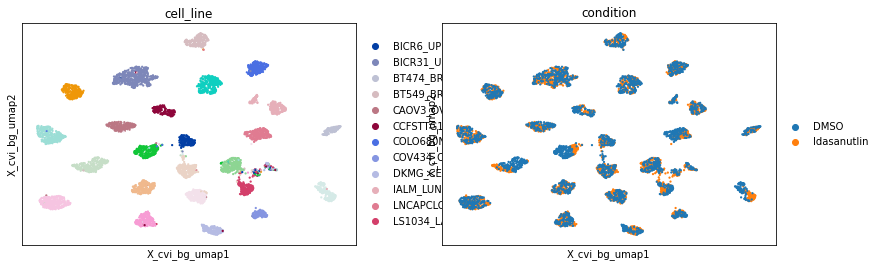

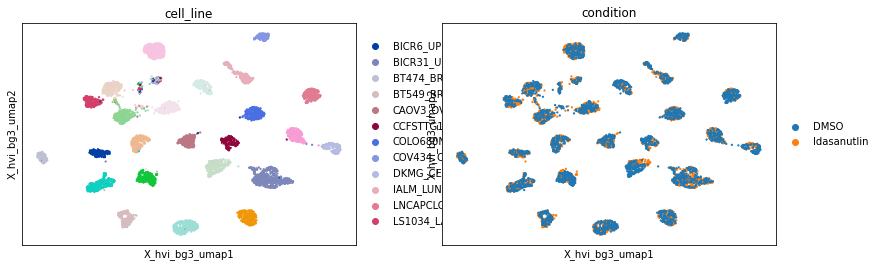

In [11]:
sc.pl.embedding(adata, basis = "X_cvi_bg_umap", color = ["cell_line", "condition"])
sc.pl.embedding(adata, basis = "X_hvi_bg3_umap", color = ["cell_line", "condition"])

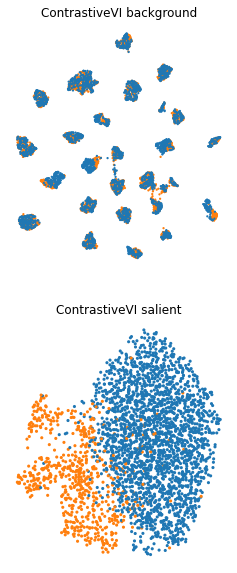

In [40]:
import matplotlib.pyplot as plt

fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(4, 10))

# sc.pl.embedding(adata, basis = "X_cvi_bg_umap", color = ["cell_line"], ax = ax1, show = False, frameon = False, title = "ContrastiveVI background", legend_loc = None)
sc.pl.embedding(adata, basis = "X_cvi_bg_umap", color = ["condition"], ax = ax2, show = False, frameon = False, title = "ContrastiveVI background", legend_loc = None)
sc.pl.embedding(target_adata, basis = "X_cvi_salient_umap", color = ["TP53_mutation_status"], ax = ax3, show = False, frameon = False, title = "ContrastiveVI salient", legend_loc = None)
fig.figure.savefig("figures/mixseq_ccvi.pdf", bbox_inches = 'tight')

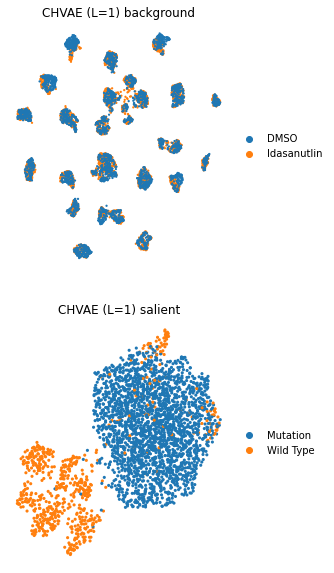

In [48]:
import matplotlib.pyplot as plt

fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(4, 10))

# sc.pl.embedding(adata, basis = "X_hvi_bg3_umap", color = ["cell_line"], ax = ax1, show = False, frameon = False, title = "CHVAE (L=3) background")
sc.pl.embedding(adata, basis = "X_hvi_bg1_umap", color = ["condition"], ax = ax2, show = False, frameon = False, title = "CHVAE (L=1) background")
sc.pl.embedding(target_adata, basis = "X_hvi_salient1_umap", color = ["TP53_mutation_status"], ax = ax3, show = False, frameon = False, title = "CHVAE (L=1) salient")
fig.figure.savefig("figures/mixseq_chvae.pdf", bbox_inches = 'tight')

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_hvi_salient1,0.640631,0.687137,0.788519,0.696843,1.0,0.988825,0.903861,0.952921,0.96325,0.145474,0.790866,0.762626,0.773922
X_hvi_salient3,0.637359,0.682886,0.79034,0.692017,0.995831,0.990371,0.90845,0.937487,0.937756,0,0.754813,0.759687,0.757737
X_hvi_salient5,0.622686,0.648335,0.768635,0.672252,0.995865,0.986721,0.899228,0.946108,0.957273,0,0.757866,0.741555,0.748079
X_cvi_salient,0.55282,0.557721,0.7223,0.586853,0.980853,0.989294,0.905123,0.979009,0.947824,0,0.76425,0.68011,0.713766
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [51]:
adata.obsm["layer1"] = model.get_latent_representation(layer = 0
)
adata.obsm["layer2"] = model.get_latent_representation(layer = 1
)
adata.obsm["layer3"] = model.get_latent_representation(layer = 2
)
adata.obsm["layer4"] = model.get_latent_representation(layer = 3
)
adata.obsm["layer5"] = model.get_latent_representation(layer = 4
)

In [54]:
reps = ["layer1", "layer2", "layer3", "layer4", "layer5"]

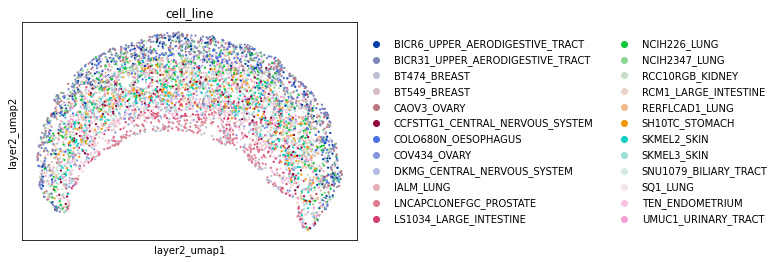

In [65]:
sc.pl.embedding(adata, basis = "layer2_umap", color = 'cell_line')